# Figure 1

We stimulated single cells as in P1902 and 3128 etc… in vitro and grew large clonal populations.  Here the clones P1 and P2 and P3 are unrelated expansions where we were able to sort large numbers of cells for scRNAseq.  We also have some in vivo cells.

The data were generated with smart-seq3 which is a more sensitive version of the old method we used in all other datasets we have (besides MR - that is 10x kits)

In [1]:
import numpy as np  # For numerical computations.
import pandas as pd  # Pandas for data analysis.
import matplotlib.pyplot as plt  # For basic plotting.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/
import statsmodels.api as sm

from IPython.display import display # Pretty display of data frames.

# Import various functions for stats.
import scipy.stats as ss
from scipy.stats import f_oneway, binom, binom_test, kruskal, norm # For p-values, kruskal-wallis, Gaussian
from scipy.stats import kurtosis, skew, zscore # For detecting bimodality
import scipy.cluster.hierarchy as sch # For hierarchical clustering.

from statsmodels.formula.api import ols

from bisect import bisect # See bisect.bisect.
from itertools import compress # Nice way to apply masks to lists, etc.


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Import from scikit, for machine learning.
# from sklearn import mixture  # Import Gaussian mixture

from sklearn import base
from sklearn.preprocessing import Binarizer, MinMaxScaler
from sklearn.model_selection import ShuffleSplit, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB # Naive Bayes Classifiers.
from sklearn.ensemble import VotingClassifier # Voting classifier.
from sklearn.svm import LinearSVC, NuSVC, SVC # Support Vector Machine 
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.manifold import TSNE

from sklearn.decomposition import PCA
import umap

# Put plots inline rather than in a pop-up.
%matplotlib inline

/opt/anaconda3/envs/Genomics/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Loading data

## Cell metadata

We begin by loading the cell metadata from a file.  

In [2]:
foldername = 'YVF2003/'
meta_df_raw = pd.read_csv(foldername + 'YFV2003_metadata_CD8.csv')
meta_df_raw.head()

,Sample_id,pMEM_score,clone_id,Day,invivo/invitro
0,YFV2003clonesP1A03_100,NaN,345.0,1401,invitro
1,YFV2003clonesP1A03_101,NaN,345.0,1401,invitro
2,YFV2003clonesP1A03_102,NaN,345.0,1401,invitro
3,YFV2003clonesP1A03_103,NaN,345.0,1401,invitro
4,YFV2003clonesP1A03_104,NaN,345.0,1401,invitro


From the raw metadata file, we extract just the sample id and clone id, and place it into a Pandas Series.  We simplify the sample names too.

In [3]:
def rename_cell(cn):
    if cn[:1] == 'Y':
        if cn[7:10] == 'inv':
            prefix = 'Invivo_cell_'
        elif cn[7:17] == 'clonesP1P2':
            prefix = 'P1P2_cell_'
        elif cn[7:18] == 'clonesP1A03':
            prefix = 'P1A03_cell_'
        suffix = cn.split('_')[1]
        return prefix + suffix
    else:
        return 'badname'

def rename_clone(cl):
    if cl == 345:
        return 'Clone_A'
    elif cl == 346:
        return 'Clone_B'
    elif cl == 347:
        return 'Clone_C'
    elif np.isnan(cl):
        return 'None'
    else:
        return 'Clone_'+str(int(cl))

meta_df = meta_df_raw[['Sample_id', 'clone_id']]
meta_df.index = [rename_cell(sid) for sid in meta_df['Sample_id']]
meta_df = meta_df.drop('Sample_id',axis=1)
meta_df = meta_df.drop(index='badname')
meta_df.clone_id = meta_df.clone_id.map(rename_clone)
meta_df = meta_df['clone_id'].astype(str)
meta_df

P1A03_cell_100     Clone_A
P1A03_cell_101     Clone_A
P1A03_cell_102     Clone_A
P1A03_cell_103     Clone_A
P1A03_cell_104     Clone_A
                    ...   
Invivo_cell_763       None
Invivo_cell_765       None
Invivo_cell_766       None
Invivo_cell_767       None
Invivo_cell_768       None
Name: clone_id, Length: 1528, dtype: object

Here we list the populations of the clones.  Note that Clone A has about twice as many cells as B and C.  We'll exploit this later. 

In [4]:
display(meta_df.value_counts())

Clone_A      387
Clone_B      192
Clone_C      191
None         124
Clone_373     23
            ... 
Clone_475      1
Clone_575      1
Clone_646      1
Clone_567      1
Clone_474      1
Name: clone_id, Length: 382, dtype: int64

In [5]:
cells = meta_df.index # All cells with metadata

## Loading gene expression

Before we load the gene expression matrices, we load gene metadata, downloaded from BioMart.  We're using GRCh37 here.

In [6]:
def get_genes(filename):
    df = pd.read_csv(filename, sep='\t',
                     index_col=0, header=0, low_memory=False)
    df.columns = ['Transcript_length', 'Gene_name', 'GC_content','Transcript stable ID', 'TSS']
    print('{} genes found in {}.'.format(len(df), filename))
    return df

In [7]:
gene_raw = get_genes('GRCh37_Biomart.txt')
gene_raw.head()

215404 genes found in GRCh37_Biomart.txt.


,Transcript_length,Gene_name,GC_content,Transcript stable ID,TSS
Gene stable ID,,,,,
ENSG00000261657,2673,SLC25A26,40.0,ENST00000566782,66119285
ENSG00000261657,1096,SLC25A26,40.0,ENST00000562780,66320895
ENSG00000261657,1840,SLC25A26,40.0,ENST00000569579,66320895
ENSG00000261657,3405,SLC25A26,40.0,ENST00000568242,66320895
ENSG00000261657,375,SLC25A26,40.0,ENST00000565530,66339287


In [8]:
gene_lengths = gene_raw['Transcript_length'].groupby(gene_raw.index).mean()
gene_GCs = gene_raw['GC_content'].groupby(gene_raw.index).mean()
gene_df = pd.DataFrame(gene_lengths, index=gene_lengths.index)
gene_df['GC_content'] = gene_GCs
gene_df['Gene_name'] = gene_raw['Gene_name'].groupby(gene_raw.index).first()
print('{} distinct Ensembl gene IDs found.'.format(len(gene_df)))
gene_df.head()

63677 distinct Ensembl gene IDs found.


,Transcript_length,GC_content,Gene_name
Gene stable ID,,,
ENSG00000000003,1350.333333,40.87,TSPAN6
ENSG00000000005,940.500000,40.80,TNMD
ENSG00000000419,974.714286,39.85,DPM1
ENSG00000000457,3274.400000,40.14,SCYL3
ENSG00000000460,2197.200000,39.22,C1orf112


Now we start loading the expression matrices.  First is a function to extract a clean expression matrix from a file.

In [9]:
def get_EM(filename):
    EM_df = pd.read_csv(filename, sep='\t', index_col=0)
    if get_genes:
        gene_names = EM_df['gene_name']
    EM_df = EM_df.drop('gene_name', axis=1) # Drop the gene name column
    EM_df.columns = [rename_cell(col) for col in EM_df.columns] # Simplify cell names as in metadata
    EM_cells = [cell for cell in EM_df.columns if cell in cells]
    EM_df = EM_df[EM_cells] # Only keep cells with metadata
    return EM_df

Each file contain UMI counts or pure reads, exons only or exons+introns, and either P1P2 or P1A03. We loop through the files, and combine P1P2 and P1A03 (all in vitro cells) in a single data frame.

Loading all the data will take a minute or so.

In [10]:
readtypes = ['umi','read']
loctypes = ['exon','inex']
Ptypes = ['P1P2','P1A03']
EM_raw = {}
for rt in readtypes:
    for lt in loctypes:
        EM_list = []
        for Pt in Ptypes:
            filename = 'YVF2003clones'+Pt+'-'+rt+'counts-'+lt+'.csv'
            EM_list.append(get_EM(foldername+filename))
        EM_raw[rt+lt] = pd.concat(EM_list,axis=1)

In [11]:
EM_raw['umiexon'].head()

,P1P2_cell_94,P1P2_cell_166,P1P2_cell_286,P1P2_cell_382,P1P2_cell_142,P1P2_cell_190,P1P2_cell_334,P1P2_cell_46,P1P2_cell_70,P1P2_cell_262,...,P1A03_cell_26,P1A03_cell_194,P1A03_cell_50,P1A03_cell_338,P1A03_cell_74,P1A03_cell_242,P1A03_cell_266,P1A03_cell_290,P1A03_cell_98,P1A03_cell_122
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000227232,0.0,0.0,2.0,1.0,0.0,1.0,0.0,4.0,0.0,0.0,...,0.0,2.0,2.0,3.0,6.0,0.0,0.0,4.0,0.0,0.0
ENSG00000243485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000237613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000268020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We check that our genes in our read matrix are also in the metadata.

In [12]:
genes = [gene for gene in EM_raw['umiexon'].index if gene in gene_df.index]
print('{} genes contained in counts and also in gene metadata.'.format(len(genes)))
gene_diff = len(EM_raw['umiexon']) - len(genes)
if gene_diff == 0:
    emoticon = ':)'
else:
    emoticon = ':('
print('{} genes have been lost {}'.format(gene_diff, emoticon))

63677 genes contained in counts and also in gene metadata.
0 genes have been lost :)


In [13]:
gene_names = gene_df['Gene_name']
print('{} ENSG gene ids loaded with {} unique gene names.'.format(len(genes), len(gene_names.unique())))
gene_names.head()

63677 ENSG gene ids loaded with 56638 unique gene names.


Gene stable ID
ENSG00000000003      TSPAN6
ENSG00000000005        TNMD
ENSG00000000419        DPM1
ENSG00000000457       SCYL3
ENSG00000000460    C1orf112
Name: Gene_name, dtype: object

While `gene_names` is useful for getting the nice name associated to an ENSG id, we create a little function to get the ENSG id from a name.  That way we can look up TNMD rather than ENSG00000000005.

In [14]:
def get_ensg(gn):
    return gene_names[gene_names==gn].index[0]

In [15]:
for rt in readtypes:
    for lt in loctypes:
        print('{} counts from {} loaded into expression matrix of size {}'.format(rt, lt, EM_raw[rt+lt].shape))

umi counts from exon loaded into expression matrix of size (63677, 766)
umi counts from inex loaded into expression matrix of size (63677, 766)
read counts from exon loaded into expression matrix of size (63677, 766)
read counts from inex loaded into expression matrix of size (63677, 766)


## Removing TCRs

We remove the TCR genes from our expression matrices, since we don't want to use these to separate clones.

In [16]:
TR_df = pd.read_csv('TR_genelist.tsv', sep='\t')
TR_symbols = TR_df['Approved symbol'].unique()
TR_ENSG = gene_names[gene_names.isin(TR_symbols)].index # Work from symbols, not ENSG here.
print('{} TCRs will be excluded.'.format(len(TR_ENSG)))

291 TCRs will be excluded.


In [17]:
for rt in readtypes:
    for lt in loctypes:
        EM_raw[rt+lt].drop(TR_ENSG, inplace=True)

Now all of the T-cell receptor genes are excluded from our analysis.  Just to check, let's print all the genes that start with TRA, TRB, TRG, TRJ.  Hopefully there shouldn't be any T-cell receptors left.

In [64]:
for greek in ['A','B','G','J']:
    print([gene for gene in gene_names[EM_raw['umiexon'].index] if gene[:2] == 'TR'+greek])

[]
[]
[]
[]


In [19]:
for rt in readtypes:
    for lt in loctypes:
        print('{} counts from {} now in expression matrix of size {}'.format(rt, lt, EM_raw[rt+lt].shape))

umi counts from exon now in expression matrix of size (63386, 766)
umi counts from inex now in expression matrix of size (63386, 766)
read counts from exon now in expression matrix of size (63386, 766)
read counts from inex now in expression matrix of size (63386, 766)


## Removing outlier cells

We begin with some quality control in the high/low UMI/reads or high/low numbers of genes expressed.

In [20]:
no_genes = {}
no_reads = {}
for rt in readtypes:
    for lt in loctypes:
        no_genes[rt+lt] = (EM_raw[rt+lt] > 0).sum()
        no_reads[rt+lt] = (EM_raw[rt+lt]).sum()
        
no_genes_df = pd.DataFrame(no_genes)
no_reads_df = pd.DataFrame(no_reads)

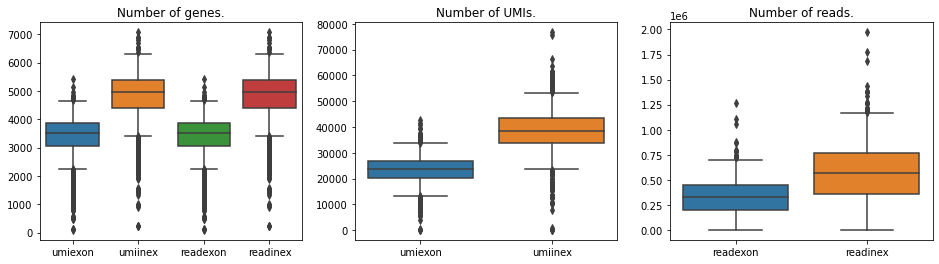

In [40]:
fig,ax = plt.subplots(1,3,figsize=(16,4))

sns.boxplot(data=no_genes_df, orient='v',ax=ax[0], whis=1.0)
sns.boxplot(data=no_reads_df[['umiexon','umiinex']], orient='v',ax=ax[1], whis=1.0)
sns.boxplot(data=no_reads_df[['readexon','readinex']], orient='v',ax=ax[2], whis=1.0)

ax[0].set_title('Number of genes.')
ax[1].set_title('Number of UMIs.')
ax[2].set_title('Number of reads.')
plt.suptitle('')
plt.show()

Next we look for any differences between the clones, in the above distributions.  We contrast clones B and C (total 383 cells) against clone A (387 cells).  We have formerly contrasted B and C and didn't find differences.

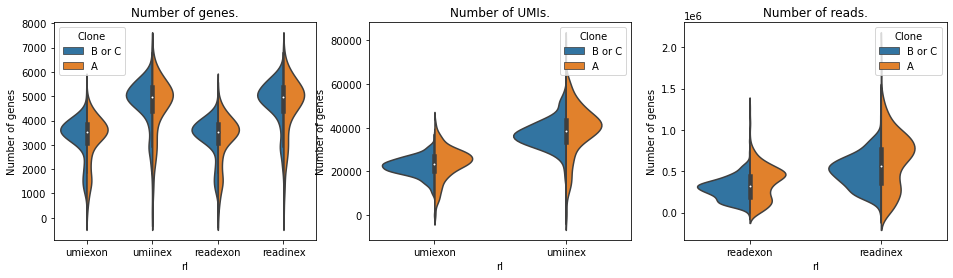

In [41]:
fig,ax = plt.subplots(1,3,figsize=(16,4))

plot_data = no_genes_df.copy()
plot_data['Clone'] = meta_df.map({'Clone_A':'A', 'Clone_B':'B or C', 'Clone_C':'B or C'})
plot_data = plot_data.melt(var_name='rl', value_name='Number of genes', id_vars='Clone')
sns.violinplot(x = 'rl', y='Number of genes', hue='Clone', data=plot_data, orient='v',ax=ax[0], split=True)

plot_data = no_reads_df[['umiexon','umiinex']].copy()
plot_data['Clone'] = meta_df.map({'Clone_A':'A', 'Clone_B':'B or C', 'Clone_C':'B or C'})
plot_data = plot_data.melt(var_name='rl', value_name='Number of genes', id_vars='Clone')
sns.violinplot(x = 'rl', y='Number of genes', hue='Clone', data=plot_data, orient='v',ax=ax[1], split=True)

plot_data = no_reads_df[['readexon','readinex']].copy()
plot_data['Clone'] = meta_df.map({'Clone_A':'A', 'Clone_B':'B or C', 'Clone_C':'B or C'})
plot_data = plot_data.melt(var_name='rl', value_name='Number of genes', id_vars='Clone')
sns.violinplot(x = 'rl', y='Number of genes', hue='Clone', data=plot_data, orient='v',ax=ax[2], split=True)

ax[0].set_title('Number of genes.')
ax[1].set_title('Number of UMIs.')
ax[2].set_title('Number of reads.')
plt.suptitle('')
plt.show()

We don't see any huge differences in the distributions between clones.  So we trim according to the overall distribution.

We see some outliers above/below the main population.  In the boxplot, the boxes represent the 25th-75th percentiles (with median bar in the middle).  The whiskers are located at 1.5 IQRs above/below the 25th and 75th, a reasonable place to declare outliers.  

The following is a general-purpose function to find all samples that are 1.5 IQRs above/below the 25th and 75th percentile.

In [42]:
def trim_cells(cell_ser, IQR_rat=1.0):
    top_Q = cell_ser.quantile(0.75)
    bot_Q = cell_ser.quantile(0.25)
    IQR = top_Q - bot_Q
    tc_high = cell_ser[cell_ser > (top_Q + IQR_rat*IQR)]
    tc_low = cell_ser[cell_ser < (bot_Q - IQR_rat*IQR)]
    return list(tc_high.index) + list(tc_low.index)

In [43]:
gene_badcells = {}
read_badcells = {}
badcells = set([]) # Empty set.
for rt in readtypes:
    for lt in loctypes:
        gene_badcells[rt+lt] = trim_cells(no_genes[rt+lt])
        read_badcells[rt+lt] = trim_cells(no_reads[rt+lt])
        oldno = len(badcells)
        badcells = badcells | (set(gene_badcells[rt+lt]) | set(read_badcells[rt+lt]))
        newno = len(badcells)
        print('{} cells filtered out.'.format(newno - oldno))

badcells = list(badcells)

174 cells filtered out.
18 cells filtered out.
14 cells filtered out.
4 cells filtered out.


In [45]:
goodcells = [cell for cell in EM_raw[rt+lt].columns if cell not in badcells]
print('{} good cells remain in the following clones.'.format(len(goodcells)))
print(meta_df.loc[goodcells].value_counts())

556 good cells remain in the following clones.
Clone_A    240
Clone_B    159
Clone_C    157
Name: clone_id, dtype: int64


Now we check to see if there are still outliers.  Hopefully most of the outliers are gone in the new distributions.  We place the whiskers at 1.5 IQRs above and below the 75th and 25th quantiles here.

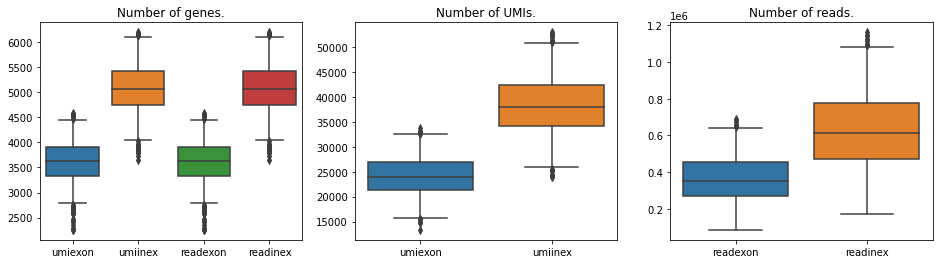

In [46]:
fig,ax = plt.subplots(1,3,figsize=(16,4))

sns.boxplot(data=no_genes_df.loc[goodcells], orient='v',ax=ax[0], whis=1.0)
sns.boxplot(data=no_reads_df.loc[goodcells][['umiexon','umiinex']], orient='v',ax=ax[1], whis=1.0)
sns.boxplot(data=no_reads_df.loc[goodcells][['readexon','readinex']], orient='v',ax=ax[2], whis=1.0)

ax[0].set_title('Number of genes.')
ax[1].set_title('Number of UMIs.')
ax[2].set_title('Number of reads.')
plt.suptitle('')
plt.show()

It's an improvement...

## Creation of normalized UMI expression matrix, and quick-clustering.  

Now we restrict to our "good" cells, and create an expression matrix.  We remove genes which are expressed (UMI count > 0) in fewer than 5% of all cells.  We normalize the matrix by scaling each cell to have total UMI count = 10000, then we log (base 2) normalize the counts.

In [47]:
def UMI_norm(EMr, cell_list, cutoff = 0.05, total=10000, log_norm = True):
    EMn = EMr[cell_list]
    is_expressed = ((EMn > 0).sum(axis=1) > (0.05*EMn.shape[1]))
    goodgenes = is_expressed[is_expressed].index
    EMn = EMn.loc[goodgenes]
    EMn = EMn * total / EMn.sum() # Total UMI count = 10000 per cell.
    EMn = EMn.T # Put cells in rows.
    if log_norm:
        EMn = np.log1p(EMn) / np.log(2) # log base 2 normalization.
    return EMn

In [48]:
EM = {}
for lt in loctypes:
    EM['umi'+lt] = UMI_norm(EM_raw['umi'+lt], goodcells)

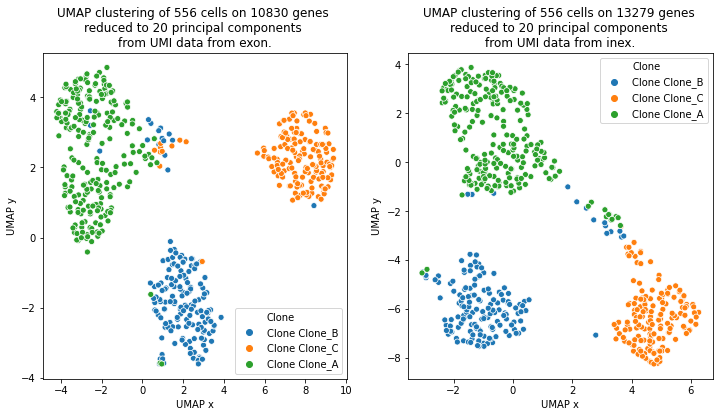

In [49]:
n_components = 20
n_neighbors = 10
min_dist = 0.25
fig, ax = plt.subplots(1,2, figsize=(12,6))

for j,lt in enumerate(loctypes):
    X = EM['umi'+lt]
    y = meta_df.loc[X.index]
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X) # Apply PCA with 10 components.
    X_embedded = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                           random_state = 42, metric='cosine').fit_transform(X_pca) # Reduce from 10 components to 2-dimensions.

    cl_df = pd.DataFrame(X_embedded, columns = ['UMAP x', 'UMAP y'], index=X.index) # Just for graphing.
    cl_df['Clone'] = ['Clone '+cl for cl in y.values]
    g = sns.scatterplot(x='UMAP x', y='UMAP y', hue='Clone', data = cl_df, ax=ax[j])
    #if j == 0:
    #    g.legend(loc='center left', bbox_to_anchor=(-0.55, 0.5), ncol=1)

    ax[j].set_title('UMAP clustering of {} cells on {} genes \n' 
                    'reduced to {} principal components \n'
                    'from UMI data from {}.'.format(X.shape[0], X.shape[1], n_components, lt))

plt.show()

We take a look to see if the awkward mixed clump in the middle is due to quality control issues -- too few genes/UMIs in cells.

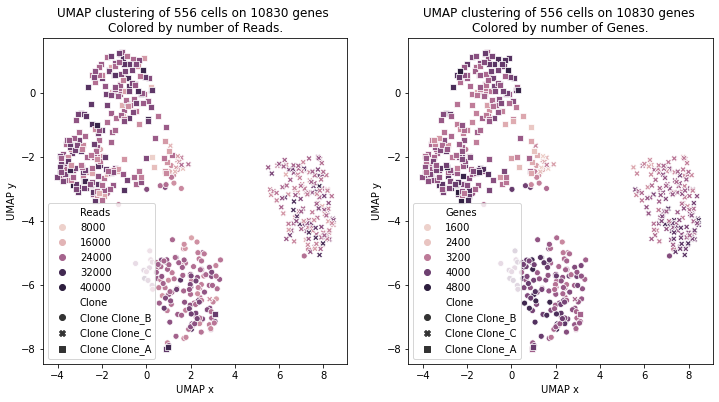

In [50]:
n_components = 20
n_neighbors = 10
min_dist = 0.25
fig, ax = plt.subplots(1,2, figsize=(12,6))

X = EM['umiexon']
y = meta_df.loc[X.index]
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X) # Apply PCA with 10 components.
X_embedded = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                        random_state = 42, metric='cosine').fit_transform(X_pca) # Reduce from 10 components to 2-dimensions.

cl_df = pd.DataFrame(X_embedded, columns = ['UMAP x', 'UMAP y'], index=X.index) # Just for graphing.
cl_df['Clone'] = ['Clone '+cl for cl in y.values]
cl_df['Reads'] = no_reads_df['umiexon']
cl_df['Genes'] = no_genes_df['umiexon']

for j,what in enumerate(['Reads','Genes']):
    g = sns.scatterplot(x='UMAP x', y='UMAP y', hue=what, style='Clone', data = cl_df, ax=ax[j])
    #if j == 0:
    #    g.legend(loc='center left', bbox_to_anchor=(-0.55, 0.5), ncol=1)

    ax[j].set_title('UMAP clustering of {} cells on {} genes \n' 
                    'Colored by number of {}.'.format(X.shape[0], X.shape[1], what))

plt.show()

This might be a quality control issue... the poorly clustered cells seem "lighter" -- fewer reads and genes.  Not too bad overall though.

## Reads:  TPM normalization

Now we carry out TPM normalization on our read data.

The following is a general purpose TPM normalizer.

In [51]:
def TPM_norm(cdf, gf, filtergenes = True):
    df = cdf.copy()
    # Step 1:  divide each entry by the transcript length of the gene, in kilobases.
    rdf = 1 / gf['Transcript_length']
    df = df.apply(lambda col : col*1000*rdf) # Multiply by 1000 to convert transcript length to kilobases.
    # Transpose for what follows.
    df = df.transpose()
    # Filter out genes that are never expressed.  Makes stuff faster.
    if filtergenes:
        tot = df.sum(axis=0)
        good_genes = [gene for gene in df.columns if tot[gene] > 0.0]
        print('{} genes filtered out, because they are never expressed.  {} genes remain.'.format(
            len(df.columns) - len(good_genes), len(good_genes)))
        df = df[good_genes]
    # Step 2:  divide each entry by cell-total, then multiply by 1,000,000.
    rdf = 1/df.sum(axis=1)
    df = df.apply(lambda col : col*rdf)
    df = df * 1000000
    # Double-check TPM normalization has succeeded.
    print('The TPM normalization has failed for {} samples.'.format(((df.sum(axis=1) - 1000000) > 0.1).sum()))
    # Return new dataframe.
    return df

Now we TPM normalize and log-normalize to make an expression matrix.  It might take a minute.

In [52]:
for lt in loctypes:
    EM['read'+lt] = TPM_norm(EM_raw['read'+lt][goodcells], gene_df) # Only use the good cells.
    EM['read'+lt] = np.log1p(EM['read'+lt]) / np.log(2) # log-base-2 normalization

EM['readexon'].head()

39631 genes filtered out, because they are never expressed.  24046 genes remain.
The TPM normalization has failed for 0 samples.
34283 genes filtered out, because they are never expressed.  29394 genes remain.
The TPM normalization has failed for 0 samples.


,ENSG00000000003,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,ENSG00000001461,...,ENSG00000273474,ENSG00000273476,ENSG00000273477,ENSG00000273478,ENSG00000273483,ENSG00000273484,ENSG00000273486,ENSG00000273488,ENSG00000273489,ENSG00000273493
P1P2_cell_94,0.0,0.000000,0.0,0.0,0.0,0.0,5.614300,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P1P2_cell_166,0.0,0.000000,0.0,0.0,0.0,0.0,4.439237,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P1P2_cell_286,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,7.834884,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P1P2_cell_382,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P1P2_cell_142,0.0,8.754858,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,4.650285,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's see how clustering on TPM-normalized reads compares to clustering on UMI data.

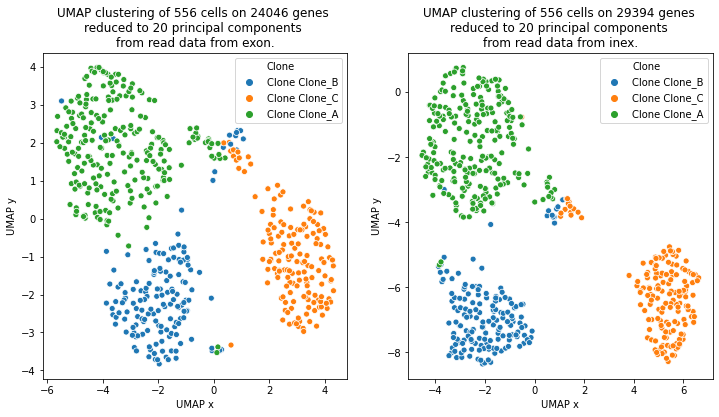

In [53]:
n_components = 20
n_neighbors = 10
min_dist = 0.25
fig, ax = plt.subplots(1,2, figsize=(12,6))

for j,lt in enumerate(loctypes):
    X = EM['read'+lt]
    y = meta_df.loc[X.index]
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X) # Apply PCA with 10 components.
    X_embedded = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                           random_state = 42, metric='cosine').fit_transform(X_pca) # Reduce from 10 components to 2-dimensions.

    cl_df = pd.DataFrame(X_embedded, columns = ['UMAP x', 'UMAP y'], index=X.index) # Just for graphing.
    cl_df['Clone'] = ['Clone '+cl for cl in y.values]
    g = sns.scatterplot(x='UMAP x', y='UMAP y', hue='Clone', data = cl_df, ax=ax[j])
    #if j == 0:
    #    g.legend(loc='center left', bbox_to_anchor=(-0.55, 0.5), ncol=1)

    ax[j].set_title('UMAP clustering of {} cells on {} genes \n' 
                    'reduced to {} principal components \n'
                    'from read data from {}.'.format(X.shape[0], X.shape[1], n_components, lt))

plt.show()

Let's look at the expression of four genes among these clusters:  PCNA, SELL, KLRD1, and GNLY.

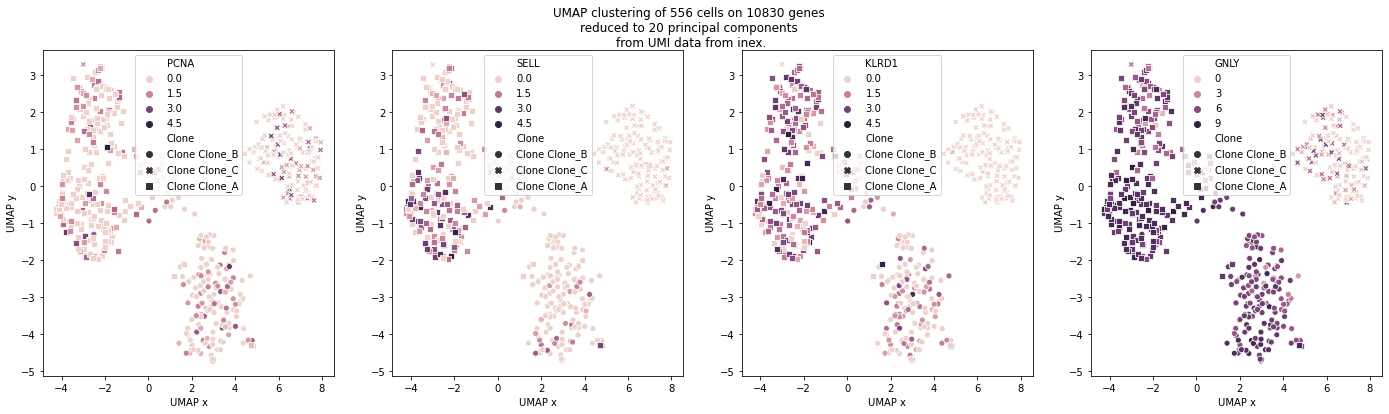

In [54]:
n_components = 20
n_neighbors = 10
min_dist = 0.25
genelist = ['PCNA', 'SELL', 'KLRD1', 'GNLY']

fig, ax = plt.subplots(1,len(genelist), figsize=(6*len(genelist),6))
X = EM['umiexon']
y = meta_df.loc[X.index]
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X) # Apply PCA with 10 components.
X_embedded = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                        random_state = 42, metric='cosine').fit_transform(X_pca) # Reduce from 10 components to 2-dimensions.

cl_df = pd.DataFrame(X_embedded, columns = ['UMAP x', 'UMAP y'], index=X.index) # Just for graphing.
cl_df['Clone'] = ['Clone '+cl for cl in y.values]

for j,gene in enumerate(genelist):
    genehot = X[get_ensg(gene)]
    cl_df[gene] = genehot
    sns.scatterplot(x='UMAP x', y='UMAP y', hue=gene, style='Clone', data = cl_df, ax=ax[j])

plt.suptitle('UMAP clustering of {} cells on {} genes \n' 
             'reduced to {} principal components \n'
             'from UMI data from {}.'.format(X.shape[0], X.shape[1], n_components, lt))

plt.show()

# Machine learning

Now we look at the accuracy of an SVM classifier on these three clones.  We split the large clone into two pieces , and randomly downsample the others to match populations.  The result is two splits of the data into three equal-size clones.

First is a generic downsampling function.

In [56]:
def downsample(X,y):
    ds = y.value_counts().min()
    y_cats = y.unique()
    X_list = []
    y_list = []
    for yc in y_cats:
        y_yc = y[y==yc].sample(n=ds)
        y_list.append(y_yc)
        X_list.append(X.loc[y_yc.index])
    return pd.concat(X_list), pd.concat(y_list)

Now we create our downsampled expression matrices and clone ids.  We use the UMI data from exons only in what follows.

In [57]:
X = EM['umiexon'].copy()
X = X[X.columns[X.sum() > 5]] # Ignore all genes with total UMI count <= 5 among all cells.

y = meta_df[X.index].sort_values()
X = X.reindex(y.index)

y_A = y[y == 'Clone_A']

y_A1 = y_A.sample(frac=0.5)
y_A2 = y_A.drop(y_A1.index)

y_1 = pd.concat([y_A1, y[y =='Clone_B'], y[y =='Clone_C']]) 
y_2 = pd.concat([y_A2, y[y =='Clone_B'], y[y =='Clone_C']])

X_1 = X.loc[y_1.index]
X_2 = X.loc[y_2.index]

X_1, y_1 = downsample(X_1,y_1)
X_2, y_2 = downsample(X_2,y_2)
display(y_1.value_counts())
display(y_2.value_counts())

Clone_C    120
Clone_B    120
Clone_A    120
Name: clone_id, dtype: int64

Clone_C    120
Clone_B    120
Clone_A    120
Name: clone_id, dtype: int64

Now we introduce our SVM pipeline, and a general-purpose function for cross-validation and visualization of accuracy.

In [58]:
SVMpipe = make_pipeline(MinMaxScaler(), 
                        SelectKBest(score_func = f_classif, k=100), 
                        LinearSVC(random_state=0, tol=1e-4, max_iter = 2000))

In [59]:
def CV_map(gs, swap=False):  # parameter_grid and grid_search.
    '''
    A general-purpose visualization for grid-search cross-validations.
    Displays predictive accuracy as a heatmap, based on different
    choices of parameters.  Displays optimal parameters in title.
    
    Args:
        gs (sklearn.model_selection.GridSearchCV):  The grid-search object.
        swap:  Set to True to switch the axes.
        
    Returns:
        None
        
    '''
    results = gs.cv_results_
    means = results['mean_test_score']
    params = list(gs.param_grid.keys())
    
    ser = pd.Series(list(means),
                  index=pd.MultiIndex.from_tuples(
                      [tuple(d.values()) for d in results['params']])
               )
    gs_df = ser.unstack().fillna(0)
    gs_df.shape 
    if swap:
        gs_df = gs_df.transpose()
        params = params[::-1] # Switch the order of the parameter list.
    
    f, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(gs_df, annot=True, square=True, fmt="2.0%", linewidths=.5, 
                cbar_kws={'fraction':0.025, 'pad':0.05}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([.5, .6, .7, .8, .9])
    cbar.set_ticklabels(['50%', '60%', '70%', '80%', '90%'])
    ax.set_xlabel(params[1])
    ax.set_ylabel(params[0])
    plt.yticks(rotation=0)
    bestacc = gs.best_score_
    ax.set_title("Result of grid-search with {0:}-fold cross-validation. \n"
                 "Best score {1:2.1%} with parameters \n"
                 "{2} ".format(gs.cv, gs.best_score_, gs.best_params_))

Now we run the SVM pipeline... twice.  Once for each half of the A-clones.

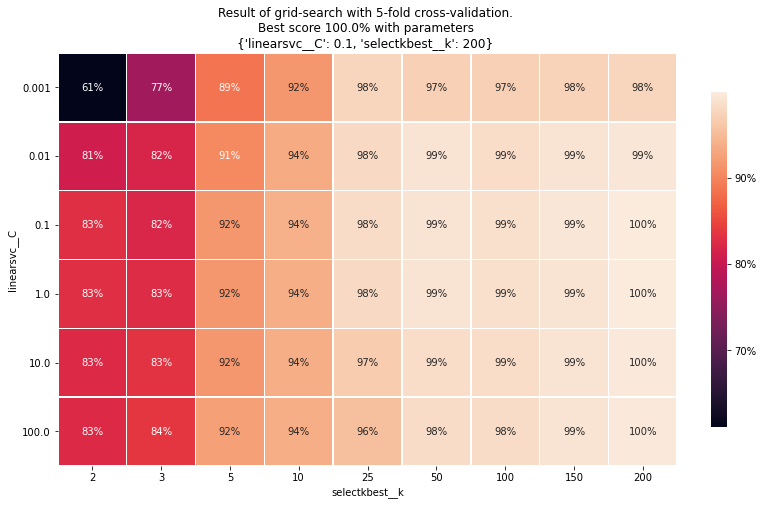

In [60]:
# DANGER DANGER:  The following suppresses all warnings from Python.
# Otherwise, you'll probably get a bunch of convergence warnings...
# Alternatively, increase the number of iterations in the SVM.

import warnings
warnings.filterwarnings('ignore') # Ignore warnings.

param_grid = dict(linearsvc__C=[0.001, 0.01, 0.1, 1.0, 10, 100],
                  selectkbest__k = [2,3,5,10,25,50,100,150,200]
                 )

grid_search = GridSearchCV(SVMpipe, param_grid=param_grid, cv=5, iid=False) #5-fold cross-validation.
grid_search.fit(X_1,y_1)

CV_map(grid_search)

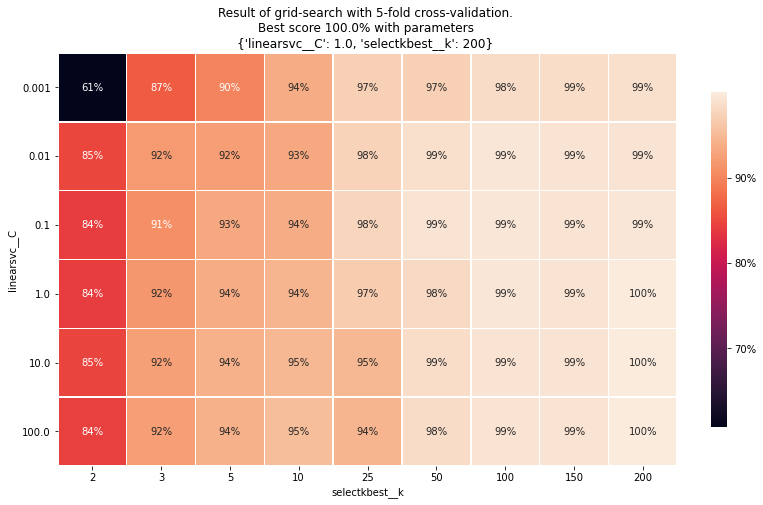

In [61]:
# DANGER DANGER:  The following suppresses all warnings from Python.
# Otherwise, you'll probably get a bunch of convergence warnings...
# Alternatively, increase the number of iterations in the SVM.

import warnings
warnings.filterwarnings('ignore') # Ignore warnings.

param_grid = dict(linearsvc__C=[0.001, 0.01, 0.1, 1.0, 10, 100],
                  selectkbest__k = [2,3,5,10,25,50,100,150,200]
                 )

grid_search = GridSearchCV(SVMpipe, param_grid=param_grid, cv=5, iid=False) #5-fold cross-validation.
grid_search.fit(X_2,y_2)

CV_map(grid_search)

# Differential expression

Here we use the ANOVA F test to measure the differential expression of genes between the three clones.  As before, we run this twice (splitting Clone A) to improve robustness of our DE gene lists.

In [65]:
def ANOVA_p(X,y):
    return pd.Series(f_classif(X, y)[1], index=X.columns, name='pval') # Built-in ANOVA F from scikit.

Fp_1 = ANOVA_p(X_1,y_1)
Fp_2 = ANOVA_p(X_2,y_2)
Fp = pd.DataFrame({'gene_name':gene_names, 'A1':Fp_1, 'A2':Fp_2}, index=Fp_1.index)
Fp = Fp.sort_values('A1')
Fp.head() # Display the top 5 genes, according to the A1 split.

,gene_name,A1,A2
Geneid,,,
ENSG00000115523,GNLY,1.373083e-98,2.726782e-88
ENSG00000167996,FTH1,1.236288e-60,1.162132e-72
ENSG00000105374,NKG7,2.006034e-59,5.756209e-73
ENSG00000134539,KLRD1,6.859926e-57,1.382587e-39
ENSG00000158869,FCER1G,7.097040e-53,1.821680e-56


Here we compare the p-values for differential expression of each gene, according to the two splits.

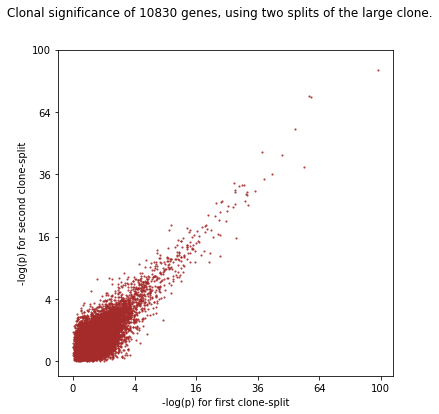

In [66]:
fig,ax = plt.subplots(figsize=(6,6))

sns.scatterplot(x='A1', y='A2', data=np.sqrt(-np.log10(Fp.drop('gene_name',axis=1))), 
                alpha=0.75, edgecolor=None, color='brown', s=2.0) # We use a square-root scale on -log_10(p).

ax.set_xlabel('-log(p) for first clone-split')
ax.set_ylabel('-log(p) for second clone-split')

ticks = [0,2,4,6,8,10]
ax.set_xticks(ticks)
ax.set_xticklabels([t*t for t in ticks])
ax.set_yticks(ticks)
ax.set_yticklabels([t*t for t in ticks])
plt.suptitle('Clonal significance of {} genes, using two splits of the large clone.'.format(len(Fp)))
plt.show()

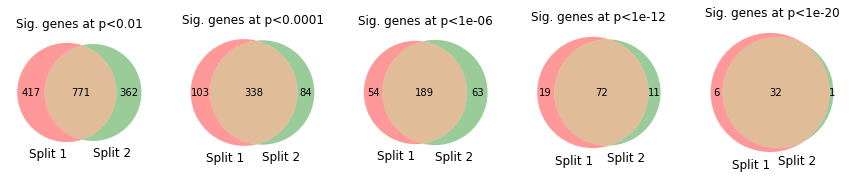

In [67]:
from matplotlib_venn import venn2, venn3

pcuts = [0.01, 0.0001, 1e-6, 1e-12, 1e-20]
fig,ax = plt.subplots(1,len(pcuts),figsize=(3*len(pcuts),4))
genes_sig = {}

for j,pcut in enumerate(pcuts):
    genes_sig_1 = Fp[Fp['A1'] < pcut].index
    genes_sig_2 = Fp[Fp['A2'] < pcut].index
    genes_sig[j] = list(set(genes_sig_1) & set(genes_sig_2))
    v = venn2([set(genes_sig_1), set(genes_sig_2)], set_labels = ('Split 1', 'Split 2'), ax=ax[j])
    ax[j].set_title('Sig. genes at p<{}'.format(pcut))
    
plt.show()

In [68]:
for j in range(len(pcuts)):
    print('{} significant genes found at p<{}.  Contained in genes_sig[{}]'.format(len(genes_sig[j]), pcuts[j],j))

771 significant genes found at p<0.01.  Contained in genes_sig[0]
338 significant genes found at p<0.0001.  Contained in genes_sig[1]
189 significant genes found at p<1e-06.  Contained in genes_sig[2]
72 significant genes found at p<1e-12.  Contained in genes_sig[3]
32 significant genes found at p<1e-20.  Contained in genes_sig[4]


Here's a somewhat generic function for heatmaps of gene expression.

In [69]:
def gene_heatmap(X,y,genelist):
    X_plot = X[genelist].T
    X_plot.index = X_plot.index.map(gene_names)
    plot_cells = [cell for cell in y.sort_values().index if cell in X_plot.columns]
    X_plot = X_plot[plot_cells]
    y_plot = y.loc[plot_cells]
    cg = sns.clustermap(X_plot, z_score=0, col_colors = y_plot.map({'Clone_A':'r','Clone_B':'y', 'Clone_C':'b'}), 
                        cmap='coolwarm', metric='cosine', vmin=-2, vmax=2, col_cluster=False)

    cg.ax_row_dendrogram.set_visible(False)
    cg.cax.set_position([1.05, .3, .03, .2])
    ax = cg.ax_heatmap
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_xticklabels([])
    ax.set_ylabel('')

    plt.suptitle('Heatmap of {} gene expressions among {} cells in {} clones.'.format(X_plot.shape[0], X_plot.shape[1],3),
                 y=0.85)
    plt.show()

We look at the heatmap for the genes that meet the p<0.0001 threshold.

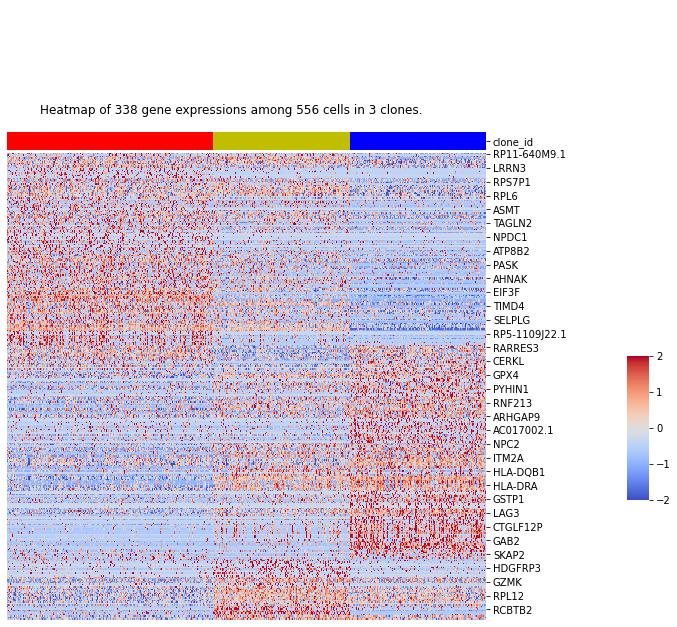

In [70]:
gene_heatmap(X,y,genes_sig[1])

Next we look at the clusters obtained by looking only at the genes meeting the p<0.0001 threshold.

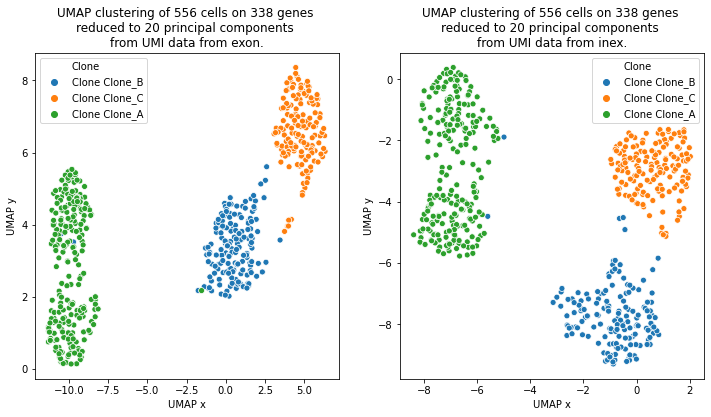

In [71]:
n_components = 20
n_neighbors = 10
min_dist = 0.25
fig, ax = plt.subplots(1,2, figsize=(12,6))

for j,lt in enumerate(loctypes):
    X = EM['umi'+lt][genes_sig[1]]
    y = meta_df.loc[X.index]
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X) # Apply PCA with 10 components.
    X_embedded = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                           random_state = 42, metric='cosine').fit_transform(X_pca) # Reduce from 10 components to 2-dimensions.

    cl_df = pd.DataFrame(X_embedded, columns = ['UMAP x', 'UMAP y'], index=X.index) # Just for graphing.
    cl_df['Clone'] = ['Clone '+cl for cl in y.values]
    g = sns.scatterplot(x='UMAP x', y='UMAP y', hue='Clone', data = cl_df, ax=ax[j])
    #if j == 0:
    #    g.legend(loc='center left', bbox_to_anchor=(-0.55, 0.5), ncol=1)

    ax[j].set_title('UMAP clustering of {} cells on {} genes \n' 
                    'reduced to {} principal components \n'
                    'from UMI data from {}.'.format(X.shape[0], X.shape[1], n_components, lt))

plt.show()

Let's look at Clone A a bit more closely, separating the two clumps we see in the UMAP plot.

In [73]:
green_clump = cl_df[cl_df['UMAP x'] < -4]
greenup = green_clump['UMAP y'] > -2.5
X_green = EM['umiexon'].loc[green_clump.index]
y_green = greenup.map({True:'A_up', False:'A_down'})

In [75]:
y_green.value_counts()

A_down    130
A_up      112
Name: UMAP y, dtype: int64

In [80]:
green_df = pd.DataFrame(ANOVA_p(X_green,y_green).sort_values())
green_df['gene name'] = gene_names
green_df

,pval,gene name
Geneid,,
ENSG00000111913,1.067319e-34,FAM65B
ENSG00000185989,2.939935e-27,RASA3
ENSG00000137441,3.020138e-27,FGFBP2
ENSG00000170989,1.256081e-26,S1PR1
ENSG00000169442,6.456474e-24,CD52
...,...,...
ENSG00000169710,9.998030e-01,FASN
ENSG00000187862,NaN,TTC24
ENSG00000251002,NaN,AE000661.37


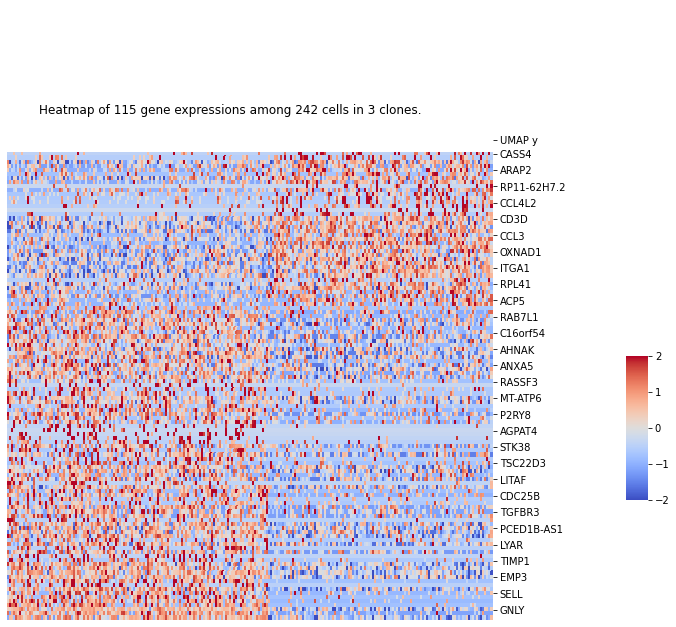

In [81]:
genes_green = green_df[green_df['pval'] < 0.0001].index
gene_heatmap(X_green,y_green,genes_green)

This seems interesting -- there are quite a few genes (more than expected by chance) that seem to distinguish the two clumps within Clone A.  These include SELL and GNLY, among many others.  (Excuse the mislabeled clones.)

# Cell size correlations

Now we look for any correlations that might exist between cell size (quantified by FCS and SSC) and gene expression in our normalized UMI matrix.  We restrict to the UMI matrix from exons only here.

In [82]:
X = EM['umiexon']
X.shape

(556, 10830)

We look closely at those genes which are "always on" in the following sense:  99% of cells have expression level above 2, in the log-normalized UMI counts.

In [83]:
X_almostmin = X.quantile(0.01)
on_genes = X_almostmin[X_almostmin > 2].index
len(on_genes)

80

Here is a list of the on-genes.  It's dominated by RPS/RPL genes, MT-genes, with some others like B2M and MALAT1 mixed in.

In [92]:
print(', '.join(gene_names[on_genes]))

RPL11, SH3BGRL3, CD52, RPS8, RPS27, RPS24, RPLP2, RPL27A, RPS13, FAU, MALAT1, RPS3, RPS25, GAPDH, RPS26, RPL6, RPLP0, RPL21, TPT1, RPS29, B2M, RPLP1, IL32, RPS15A, RPL13, RP11-849F2.7, RPL23A, CCL5, RPL19, RPL17-C18orf32, RPS15, RPL18A, RPS16, RPS19, RPL18, RPL13A, RPS11, NKG7, RPS9, RPS27A, TMSB10, RPL31, RPL37A, RPL3, RPL15, RPSA, RPL29, RPL35A, RPL34, RPS3A, RPL37, RPS23, RPS14, GNB2L1, HLA-A, HLA-C, HLA-B, RPS18, EEF1A1, ACTB, RPS20, RPL30, RPS6, RPL35, RPL12, EEF1A1P5, RPL7A, MT-RNR1, MT-RNR2, MT-ND1, MT-ND2, MT-CO1, MT-CO2, MT-ATP6, MT-ND3, MT-ND4L, MT-CYB, TMSB4X, RPS4X, RPL10


The FCS and SSC numbers (related to cell size) are loaded from a file below.

In [84]:
PMD = pd.read_csv('Protein_Meta_Data_InVitro_YF2003_P1A03P1P2.csv', index_col=0, header = 1)
PMD.head()

,Unnamed: 1,Unnamed: 2,Unnamed: 3,FCS 488-200,SSC 488-200,*530/40 488-200,*610/20 488-200,*692/40 488-200,*670/30 640-120,*750 LP 640-120,*520/35 405-100,*460/50 405-100
Sample_ID,Well,Clone_ID,Events,Mean,Mean,Mean,Mean,Mean,Mean,Mean,Mean,Mean
YVF2003clonesP1P2_1,A1,346,1,33483,22072,115,25,46,11,3,1,1
YVF2003clonesP1P2_2,A2,346,1,36494,18666,78,12,34,17,28,6,6
YVF2003clonesP1P2_3,A3,346,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YVF2003clonesP1P2_4,A4,346,1,35185,13247,44,27,26,8,11,4,2


We extract the relevant FCS and SSC data and put it into a simple dataframe, with cell names matching as before.

In [85]:
cell_sizes = PMD[['FCS 488-200', 'SSC 488-200']]
cell_sizes.index = cell_sizes.index.map(rename_cell)
cell_sizes.columns = ['FCS', 'SSC']
cell_sizes = cell_sizes.loc[X.index]
cell_sizes = cell_sizes.astype(float)
#cell_sizes = cell_sizes.dropna()
cell_sizes.head()

,FCS,SSC
P1P2_cell_94,42674.0,21771.0
P1P2_cell_166,40430.0,26377.0
P1P2_cell_286,48814.0,15158.0
P1P2_cell_382,46710.0,19682.0
P1P2_cell_142,41638.0,17796.0


We compute correlations to *all* genes in our expression matrix (UMI exon based).

In [86]:
sizecorr_df = pd.DataFrame(index=X.columns)
sizecorr_df['FCS'] = X.corrwith(cell_sizes['FCS'])
sizecorr_df['SSC'] = X.corrwith(cell_sizes['SSC'])
sizecorr_df.head()

,FCS,SSC
Geneid,,
ENSG00000227232,0.062427,0.070275
ENSG00000237683,0.001672,0.070375
ENSG00000241860,0.032982,0.060144
ENSG00000228463,0.011152,0.035193
ENSG00000237094,0.036290,0.061914


To look for unusual correlations, we plot a histogram of the Pearson r values for all genes, on a log-scale.  This should look like a log-scaled Beta distribution I think.

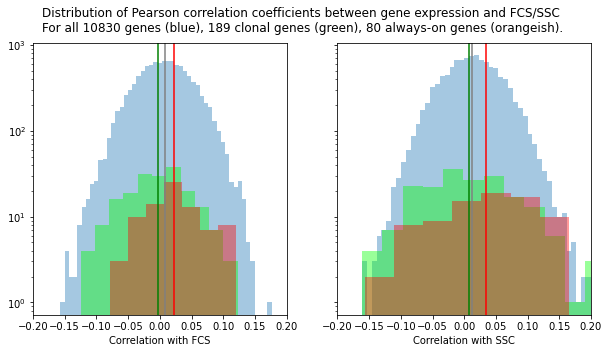

In [87]:
fig,ax = plt.subplots(1,2,figsize=(10,5), sharey=True, sharex=True)

for j,meas in enumerate(['FCS','SSC']):
    data = sizecorr_df[meas]
    sns.distplot(data, kde=False, ax=ax[j])
    sns.distplot(data[genes_sig[2]], kde=False, color=(0,1,0,0.2), ax=ax[j])
    sns.distplot(data[on_genes], kde=False, color=(1,0,0,0.2), ax=ax[j])
    ax[j].axvline(data.mean(), color='gray')
    ax[j].axvline(data[genes_sig[2]].mean(), color='green')
    ax[j].axvline(data[on_genes].mean(), color='red')
    ax[j].set_xlabel('Correlation with {}'.format(meas))

plt.xlim(-0.2,0.2)
plt.yscale('log')
plt.suptitle('Distribution of Pearson correlation coefficients between gene expression and FCS/SSC \n'
            'For all {} genes (blue), {} clonal genes (green), {} always-on genes (orangeish).'.format(
            len(data), len(genes_sig[2]), len(on_genes)))

plt.show()

There might be a *slight* rightward shift on the right graph, meaning a bit more positive correlation than expected by chance, when looking at the *always-on genes* and SSC.  We examine this a bit more closely below.

In [93]:
def cell_size_corr(gn):
    if gn[:4] == 'ENSG':
        gene = gn
    else:
        gene = get_ensg(gn)
    fig,ax = plt.subplots(1,2,figsize=(10,3), sharey=True)
    sns.regplot(cell_sizes['SSC'], X[gene], ax=ax[0])
    sns.regplot(cell_sizes['FCS'], X[gene], ax=ax[1])
    ax[0].set_ylabel(gn)
    ax[1].set_ylabel('')
    ax[0].set_title('Correlation between {} and SSC'.format(gn))
    ax[1].set_title('Correlation between {} and FCS'.format(gn))
    plt.ylim(X[gene].quantile(0.1),X[gene].quantile(0.9))
    plt.show()

Let's look at a few genes with $r > 0.2$.

In [94]:
gene_names[sizecorr_df[sizecorr_df['SSC'] > 0.2].index]

Geneid
ENSG00000158869    FCER1G
ENSG00000264538    SUZ12P
ENSG00000087086       FTL
Name: Gene_name, dtype: object

In [98]:
gene_names[sizecorr_df[sizecorr_df['FCS'] > 0.2].index]

Series([], Name: Gene_name, dtype: object)

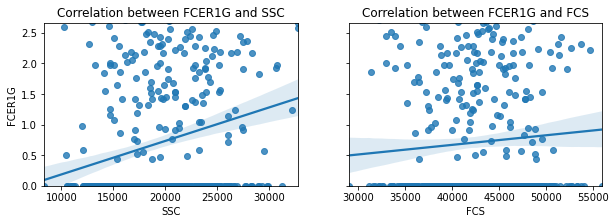

In [96]:
cell_size_corr('FCER1G')

Are these correlated genes clonal?  Let's check.

In [97]:
Fp.loc[sizecorr_df[sizecorr_df['SSC'] > 0.2].index]

,gene_name,A1,A2
Geneid,,,
ENSG00000158869,FCER1G,7.097040e-53,1.821680e-56
ENSG00000264538,SUZ12P,2.679083e-02,9.015141e-01
ENSG00000087086,FTL,2.684740e-10,1.041611e-11


# Comparison of significant genes with P9855

Let's see if there's an overlap between the clonal genes we found in this experiment, and the clonal genes from P9855.  (Same human donor, I think.)

In [101]:
Fp_9855 = pd.read_csv('P9855_clonalgenes.csv', index_col=0)
Fp_9855.head()

,F,p,logp
ENSG00000000419,1.028906,0.491184,0.308756
ENSG00000000457,1.033881,0.485703,0.313629
ENSG00000000460,1.224516,0.304779,0.516014
ENSG00000001036,2.076253,0.028856,1.539770
ENSG00000001084,0.930641,0.605065,0.218198


In [102]:
Fp.head()

,gene_name,A1,A2
Geneid,,,
ENSG00000115523,GNLY,1.373083e-98,2.726782e-88
ENSG00000167996,FTH1,1.236288e-60,1.162132e-72
ENSG00000105374,NKG7,2.006034e-59,5.756209e-73
ENSG00000134539,KLRD1,6.859926e-57,1.382587e-39
ENSG00000158869,FCER1G,7.097040e-53,1.821680e-56


In [103]:
share_genes = [gene for gene in Fp_9855.index if gene in Fp.index]
len(share_genes)

8396

8396 genes have associated clonal p-values for both experiments.  We make a dataframe with information from both experiments.

In [104]:
sigcomp_df = Fp.loc[share_genes].copy()
sigcomp_df['P9855'] = Fp_9855['p']
sigcomp_df

,gene_name,A1,A2,P9855
Geneid,,,,
ENSG00000000419,DPM1,0.629106,0.794286,0.491184
ENSG00000000457,SCYL3,0.934143,0.703715,0.485703
ENSG00000000460,C1orf112,0.458394,0.056886,0.304779
ENSG00000001036,FUCA2,0.048250,0.624431,0.028856
ENSG00000001084,GCLC,0.224026,0.072279,0.605065
...,...,...,...,...
ENSG00000273319,RP11-138A9.2,0.002998,0.405492,0.074433
ENSG00000273344,PAXIP1-AS1,0.498149,0.078499,0.455795
ENSG00000273356,RP11-804H8.6,0.078350,0.730388,0.938477


Now we plot overlaps, at various levels of statistical significance.

IL17RB, TXK, ACTB, CAPZB, VDAC3, ABCB1, FTL, GZMB, NFKBIA, KLRB1, GZMK, GNLY, SOX4, SNX6, EIF3G, ALOX5AP, KLRD1, KLRC1, XCL1, GZMA, TIMD4, TXNDC11, CHD1, ZNF577, CCL5, TRAT1, HPGD, BRWD3, B2M, LAIR2, CD8B, TCEAL1, GOLIM4, MSC, CCR3, SELL, S100A4, CCL4L2, S100A10, EGFL6, LAYN, CCL4L1, TMSB4X, RP4-728D4.2, MRPS6, FAM13A-AS1
-----
TRAT1, KLRB1, CD8B, ABCB1, FTL, ALOX5AP, TXK, HPGD, EGFL6, GZMA, LAIR2, S100A10, SELL, GNLY, KLRD1, IL17RB, TIMD4, S100A4, GZMK, CCL4L1, CCL4L2


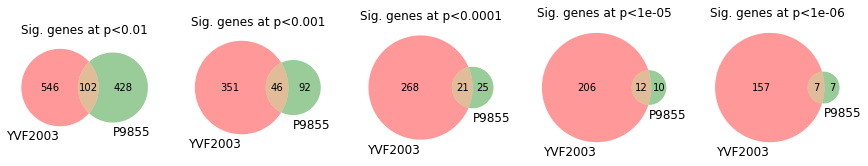

In [105]:
pcuts = [0.01, 0.001, 0.0001, 1e-5, 1e-6]
fig,ax = plt.subplots(1,len(pcuts),figsize=(3*len(pcuts),4))
plot_df = pd.DataFrame(index = sigcomp_df.index)
plot_df['YVF2003'] = sigcomp_df[['A1','A2']].max(axis=1)
plot_df['P9855'] = sigcomp_df['P9855']

for j,pcut in enumerate(pcuts):
    genes_sig_Y = plot_df[plot_df['YVF2003'] < pcut].index
    genes_sig_P = plot_df[plot_df['P9855'] < pcut].index
    genes_comm = list(set(genes_sig_Y) & set(genes_sig_P))
    v = venn2([set(genes_sig_Y), set(genes_sig_P)], set_labels = ('YVF2003', 'P9855'), ax=ax[j])
    ax[j].set_title('Sig. genes at p<{}'.format(pcut))
    if j == 2:
        print(', '.join(gene_names[genes_sig_P].values))
        print('-----')
        print(', '.join(gene_names[genes_comm].values))
plt.show()